In [3]:
import geopandas as gpd
import pandas as pd
import fiona
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm import tqdm
import rasterio
import numpy as np
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

In [4]:
african_isos = [
    'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI', 
    'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'CIV', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 
    'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 
    'TGO', 'UGA', 'ZMB', 'ZWE'
]

In [15]:
global_dams = pd.read_csv(resolve_path(config['Global_Dam_Data_csv_path']))

africa_dams = global_dams[global_dams['ISO'].isin(african_isos)].copy()
africa_dams.to_csv(resolve_path(config['Africa_Dam_csv_path']))

# Ensure Long__res_ and Lat__res_ are treated as numeric
africa_dams.loc[:, 'Long__res_'] = pd.to_numeric(africa_dams['Long__res_'], errors='coerce')
africa_dams.loc[:, 'Lat__res_'] = pd.to_numeric(africa_dams['Lat__res_'], errors='coerce')

# Strip whitespace from ISO column just in case
africa_dams.loc[:, 'ISO'] = africa_dams['ISO'].str.strip()

# Check for rows where both Long__res_ and Lat__res_ are 0
zero_coords = (africa_dams['Long__res_'] == 0) & (africa_dams['Lat__res_'] == 0)

# Calculate the proportion
proportion_zeroes = zero_coords.sum() / len(africa_dams)

print(f"The proportion of data with null coordinates is {proportion_zeroes:.2%}")


The proportion of data points with 0s in both columns is 24.65%


/tmp/ipykernel_804923/1701735062.py:16: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_joined.plot()


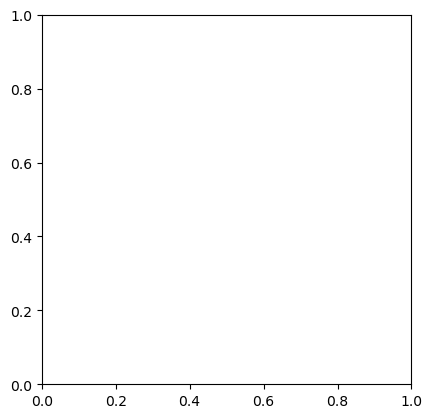

In [35]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)

# Load the CPIS shapefile
gdf_cpis = gpd.read_file(resolve_path(config['Combined_CPIS_shp_path']))

# Ensure both GeoDataFrames use the same CRS
gdf_dams = gdf_dams.set_crs("EPSG:3857")
gdf_cpis = gdf_cpis.to_crs("EPSG:3857")

# Calculate distances from each CPIS to the nearest dam
gdf_cpis['nearest_dam_distance'] = gdf_cpis.geometry.apply(lambda x: gdf_dams.distance(x).min())/1000

# Statistical summary of distances
distance_summary = gdf_cpis['nearest_dam_distance'].describe()
print(distance_summary)

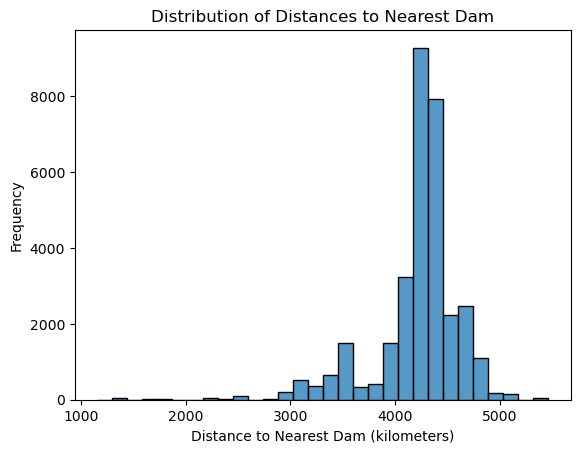

T-statistic: -2538.61133952831, P-value: 0.0


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp

# Plot histogram of distances
sns.histplot(gdf_cpis['nearest_dam_distance'], bins=30)
plt.xlabel('Distance to Nearest Dam (kilometers)')
plt.ylabel('Frequency')
plt.title('Distribution of Distances to Nearest Dam')
plt.show()

# Hypothesis testing (e.g., test if mean distance is less than 10 km)
threshold_distance = 10000  # 10 km
t_stat, p_value = ttest_1samp(gdf_cpis['nearest_dam_distance'], threshold_distance)
print(f"T-statistic: {t_stat}, P-value: {p_value}")